In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [2]:
# Adjust paths as necessary
path_to_train = 'sample_data/train.csv'

# Load the datasets
train_data = pd.read_csv(path_to_train)

# Prepare the data
X = train_data.drop('Transported', axis=1)
y = train_data['Transported'].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Display some of the training data
print(X_train.head())
print(y_train.head())

# Define columns
categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Set up preprocessing for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean of the column
    ('scaler', StandardScaler()),                # Scale data to have mean=0 and variance=1
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Generate polynomial and interaction features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Convert categorical data into dummy/indicator variables
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Initialize the model with a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Create the pipeline with preprocessing and the model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Setup grid search to explore different tree configurations
param_grid = {
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 10, 20],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_clf = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_clf.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_clf.best_params_)
print("Best score:", grid_clf.best_score_)


     PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
2333     2513_01      Earth     False       NaN  TRAPPIST-1e  28.0  False   
2589     2774_02      Earth     False   F/575/P  TRAPPIST-1e  17.0  False   
8302     8862_04     Europa      True   C/329/S  55 Cancri e  28.0  False   
8177     8736_02       Mars     False  F/1800/P  TRAPPIST-1e  20.0  False   
500      0539_02     Europa      True    C/18/P  55 Cancri e  36.0  False   

      RoomService  FoodCourt  ShoppingMall    Spa  VRDeck               Name  
2333          0.0       55.0           0.0  656.0     0.0     Loree Mathison  
2589          0.0     1195.0          31.0    0.0     0.0  Crisey Mcbriddley  
8302          0.0        0.0           0.0    0.0     0.0     Alramix Myling  
8177          NaN        2.0         289.0  976.0     0.0          Tros Pota  
500           0.0        0.0           0.0    0.0     0.0     Achyon Nalanet  
2333    0
2589    0
8302    1
8177    1
500     1
Name: Transpo

In [3]:
# Display best parameters and best score
print("Best parameters:", grid_clf.best_params_)
print("Best score:", grid_clf.best_score_)

Best parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best score: 0.7773961075568014


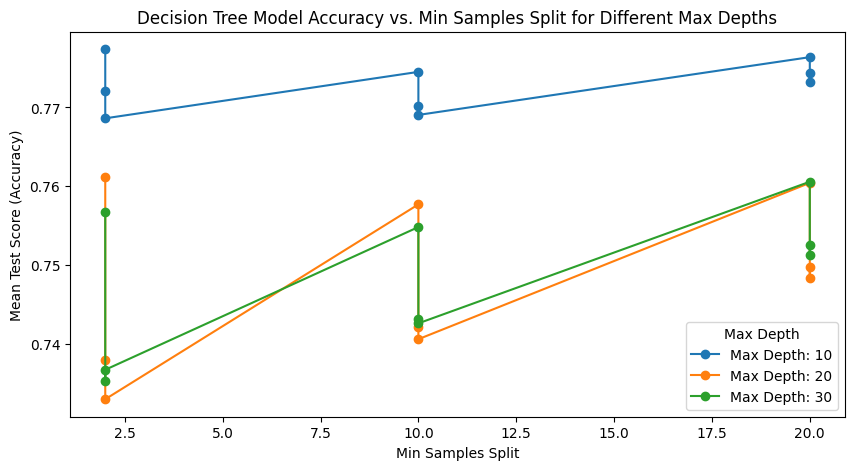

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'grid_clf' is your GridSearchCV object for the Decision Tree
results = pd.DataFrame(grid_clf.cv_results_)

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 5))

# Extract and plot mean test score (accuracy) for each 'max_depth' value
for label, df in results.groupby('param_model__max_depth'):
    df = df.sort_values(by='param_model__min_samples_split')
    ax.plot(df['param_model__min_samples_split'], df['mean_test_score'], marker='o', label=f'Max Depth: {label}')
ax.set_title('Decision Tree Model Accuracy vs. Min Samples Split for Different Max Depths')
ax.set_xlabel('Min Samples Split')
ax.set_ylabel('Mean Test Score (Accuracy)')
ax.legend(title='Max Depth')

plt.show()


Accuracy: 0.7711
Mean Squared Error: 0.2289


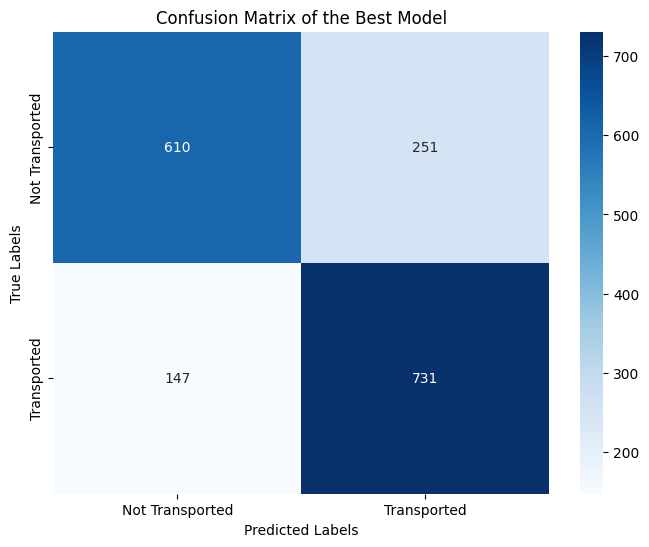

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using the best estimator from GridSearchCV
best_model = grid_clf.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.4f}")
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of the Best Model')
plt.show()
